# Projet NLP : NER avec CamemBERT (Transformers)

## Reconnaissance des Entités Nommées en français avec Fine-tuning de Transformers

## 1. Introduction

### 1.1 Contexte

Ce notebook explore l'utilisation de **CamemBERT**, un modèle Transformer pré-entraîné sur des corpus français massifs, pour la tâche de Reconnaissance des Entités Nommées (NER).

### 1.2 Approche Transformers vs CRF

**CRF (notebook précédent) :**
- Modèle séquentiel classique basé sur des features manuelles
- Entraînement from scratch sur le corpus
- Rapide, léger, ne nécessite pas de GPU
- Performance limitée par les features extraites

**CamemBERT (ce notebook) :**
- Modèle Transformer pré-entraîné sur 138 GB de texte français
- Comprend le contexte bidirectionnel profond
- Fine-tuning sur notre tâche spécifique
- Meilleure performance attendue (+10-20% F1)
- Nécessite plus de ressources (GPU recommandé)

### 1.3 Dataset

MultiCoNER v2 (français) : 68 types d'entités nommées, format BIO
- Train : 16,548 phrases
- Dev : 857 phrases
- Test : 249,786 phrases

## 2. Installation et imports

In [ ]:
# Installation des dépendances (à exécuter une seule fois)
# !pip install transformers torch datasets seqeval accelerate

## Colab (recommandé)

1. Activer GPU : Runtime → Change runtime type → GPU
2. Uploader `data.zip` (contenant `data/fr_train.conll`, `data/fr_dev.conll`, `data/fr_test.conll`)
3. Exécuter la cellule suivante

In [ ]:
# Détection Colab + téléchargement automatique des données depuis GitHub
from pathlib import Path
import urllib.request

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

BASE_DIR = Path("/content") if IN_COLAB else Path("..")

if IN_COLAB:
    print("Colab détecté. Téléchargement des données depuis GitHub...")

    # Créer le dossier data
    data_dir = BASE_DIR / "data"
    data_dir.mkdir(parents=True, exist_ok=True)

    # URLs GitHub des fichiers CoNLL (raw content)
    github_raw_url = "https://raw.githubusercontent.com/Badji-M/NLP/main/data"
    files_to_download = ["fr_train.conll", "fr_dev.conll", "fr_test.conll"]

    for filename in files_to_download:
        url = f"{github_raw_url}/{filename}"
        filepath = data_dir / filename
        print(f"Téléchargement {filename}...", end=" ")
        try:
            urllib.request.urlretrieve(url, filepath)
            print(f"✓ ({filepath.stat().st_size / (1024*1024):.1f} MB)")
        except Exception as e:
            print(f"✗ Erreur : {e}")

    print("\nDonnées téléchargées dans", data_dir)

print("BASE_DIR =", BASE_DIR)

Colab détecté. Téléchargement des données depuis GitHub...
Téléchargement fr_train.conll... ✓ (4.1 MB)
Téléchargement fr_dev.conll... ✓ (0.2 MB)
Téléchargement fr_test.conll... ✓ (58.8 MB)

Données téléchargées dans /content/data
BASE_DIR = /content


In [ ]:
# Installation de seqeval si manquant
!pip install seqeval

# Imports système et manipulation de données
import os
import json
import time
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers et PyTorch
import torch
from transformers import (
    CamembertForTokenClassification,
    CamembertTokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict

# Métriques
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Vérification GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")
if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
else:
    print("Attention : CPU détecté. L'entraînement sera lent.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=d564b364e0a1bbdfa5fa12b8f8deb5bee7314d15f941f6664bd386f9029fe310
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
Device utilisé : cuda
GPU : Tesla T4


## 3. Chargement des données

### 3.1 Configuration des chemins

In [ ]:
# DATA_DIR = Path("..") / "data"
DATA_DIR = BASE_DIR / "data"
train_path = DATA_DIR / "fr_train.conll"
dev_path   = DATA_DIR / "fr_dev.conll"
test_path  = DATA_DIR / "fr_test.conll"

# Vérification
for p in [train_path, dev_path, test_path]:
    print(f"{p.name:20s} -> {p.exists()}")

fr_train.conll       -> True
fr_dev.conll         -> True
fr_test.conll        -> True


### 3.2 Fonction de lecture CoNLL

In [ ]:
def read_conll(path):
    """
    Lit un fichier CoNLL et retourne les phrases et labels.

    Format CoNLL : token TAB _ TAB _ TAB label, phrases séparées par lignes vides
    Format réel : elle _ _ O
                  porte _ _ O
                  susan _ _ B-Artist

    Returns:
        sentences: List[List[str]] - liste de phrases (liste de tokens)
        labels: List[List[str]] - liste de labels BIO correspondants
    """
    sentences = []
    labels = []

    current_sentence = []
    current_labels = []

    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # Ignorer les lignes vides et les commentaires
            if not line or line.startswith("#"):
                if current_sentence:
                    sentences.append(current_sentence)
                    labels.append(current_labels)
                    current_sentence = []
                    current_labels = []
                continue

            # Extraction token et label (format : token TAB _ TAB _ TAB label)
            parts = line.split()
            if len(parts) >= 4:
                token = parts[0]
                label = parts[3]

                current_sentence.append(token)
                current_labels.append(label)

    # Dernière phrase si le fichier ne se termine pas par une ligne vide
    if current_sentence:
        sentences.append(current_sentence)
        labels.append(current_labels)

    return sentences, labels

### 3.3 Chargement des trois ensembles

In [ ]:
print("Chargement des données...")
train_sentences, train_labels = read_conll(train_path)
dev_sentences, dev_labels = read_conll(dev_path)
test_sentences, test_labels = read_conll(test_path)

print("\nStatistiques :")
print(f"Train : {len(train_sentences):6,} phrases, {sum(len(s) for s in train_sentences):8,} tokens")
print(f"Dev   : {len(dev_sentences):6,} phrases, {sum(len(s) for s in dev_sentences):8,} tokens")
print(f"Test  : {len(test_sentences):6,} phrases, {sum(len(s) for s in test_sentences):8,} tokens")

print("\nExemple (première phrase train) :")
print(f"Tokens : {train_sentences[0][:10]}...")
print(f"Labels : {train_labels[0][:10]}...")

Chargement des données...

Statistiques :
Train : 16,548 phrases,  247,743 tokens
Dev   :    857 phrases,   13,062 tokens
Test  : 249,786 phrases, 3,742,924 tokens

Exemple (première phrase train) :
Tokens : ['elle', 'porte', 'le', 'nom', 'de', 'la', 'romancière', 'américaine', 'susan', 'sontag']...
Labels : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Artist', 'I-Artist']...


## 4. Préparation des labels

### 4.1 Construction du mapping label-to-id

In [ ]:
# Récupération de tous les labels uniques
all_labels = set()
for labels in train_labels + dev_labels + test_labels:
    all_labels.update(labels)

# Tri pour reproductibilité
unique_labels = sorted(list(all_labels))

# Création des mappings
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

num_labels = len(unique_labels)

print(f"Nombre de labels uniques : {num_labels}")
print(f"\nPremiers labels : {unique_labels[:10]}")
print(f"Derniers labels : {unique_labels[-10:]}")

# Statistiques sur les entités
entity_labels = [l for l in unique_labels if l.startswith('B-')]
print(f"\nNombre de types d'entités (B-) : {len(entity_labels)}")

Nombre de labels uniques : 67

Premiers labels : ['B-AerospaceManufacturer', 'B-AnatomicalStructure', 'B-ArtWork', 'B-Artist', 'B-Athlete', 'B-CarManufacturer', 'B-Cleric', 'B-Clothing', 'B-Disease', 'B-Drink']
Derniers labels : ['I-Scientist', 'I-Software', 'I-SportsGRP', 'I-SportsManager', 'I-Station', 'I-Symptom', 'I-Vehicle', 'I-VisualWork', 'I-WrittenWork', 'O']

Nombre de types d'entités (B-) : 33


### 4.2 Conversion en format Hugging Face Dataset

In [ ]:
def create_dataset(sentences, labels):
    """
    Convertit les données au format Hugging Face Dataset.

    Args:
        sentences: List[List[str]]
        labels: List[List[str]]

    Returns:
        Dataset avec colonnes 'tokens' et 'ner_tags'
    """
    # Conversion des labels en IDs
    ner_tags = [[label2id[label] for label in sent_labels] for sent_labels in labels]

    return Dataset.from_dict({
        "tokens": sentences,
        "ner_tags": ner_tags
    })

# Création des datasets
train_dataset = create_dataset(train_sentences, train_labels)
dev_dataset = create_dataset(dev_sentences, dev_labels)
test_dataset = create_dataset(test_sentences, test_labels)

# Création du DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": dev_dataset,
    "test": test_dataset
})

print(dataset)
print("\nExemple du dataset train :")
print(train_dataset[0])

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 16548
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 857
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 249786
    })
})

Exemple du dataset train :
{'tokens': ['elle', 'porte', 'le', 'nom', 'de', 'la', 'romancière', 'américaine', 'susan', 'sontag', '(', '1933', '2004', ')', '.'], 'ner_tags': [66, 66, 66, 66, 66, 66, 66, 66, 3, 36, 66, 66, 66, 66, 66]}


## 5. Tokenization avec CamemBERT

### 5.1 Chargement du tokenizer

CamemBERT utilise un tokenizer SentencePiece (subword tokenization) qui découpe les mots en sous-unités. Cela nécessite un alignement spécial avec les labels NER.

In [ ]:
model_checkpoint = "camembert-base"
tokenizer = CamembertTokenizerFast.from_pretrained(model_checkpoint)

print(f"Tokenizer chargé : {model_checkpoint}")
print(f"Vocabulaire : {tokenizer.vocab_size:,} tokens")

# Test du tokenizer
exemple = "La romancière américaine Susan Sontag"
tokens = tokenizer.tokenize(exemple)
print(f"\nExemple de tokenization :")
print(f"Texte  : {exemple}")
print(f"Tokens : {tokens}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Tokenizer chargé : camembert-base
Vocabulaire : 32,005 tokens

Exemple de tokenization :
Texte  : La romancière américaine Susan Sontag
Tokens : ['▁La', '▁roman', 'cière', '▁américaine', '▁Susan', '▁Son', 'tag']


### 5.2 Fonction de tokenization et alignement des labels

Problématique : Un mot peut être découpé en plusieurs subwords. Il faut aligner les labels NER correctement.

Stratégie :
- Le premier subword d'un mot reçoit le label du mot
- Les subwords suivants reçoivent -100 (ignorés dans le calcul de la loss)

In [ ]:
def tokenize_and_align_labels(examples):
    """
    Tokenize les mots et aligne les labels NER avec les subwords.

    Args:
        examples: batch du dataset avec 'tokens' et 'ner_tags'

    Returns:
        dict avec input_ids, attention_mask, labels alignés
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=False  # Le DataCollator gérera le padding
    )

    labels = []
    for i, label_ids in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids_aligned = []

        previous_word_idx = None
        for word_idx in word_ids:
            # Tokens spéciaux (CLS, SEP, PAD) -> -100
            if word_idx is None:
                label_ids_aligned.append(-100)
            # Début d'un nouveau mot -> label du mot
            elif word_idx != previous_word_idx:
                label_ids_aligned.append(label_ids[word_idx])
            # Continuation d'un mot (subword) -> -100
            else:
                label_ids_aligned.append(-100)

            previous_word_idx = word_idx

        labels.append(label_ids_aligned)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Application de la tokenization
print("Tokenization des datasets...")
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names
)

print("\nDatasets tokenizés :")
print(tokenized_dataset)
print("\nExemple tokenizé :")
print(f"input_ids : {tokenized_dataset['train'][0]['input_ids'][:20]}...")
print(f"labels    : {tokenized_dataset['train'][0]['labels'][:20]}...")

Tokenization des datasets...


Map:   0%|          | 0/16548 [00:00<?, ? examples/s]

Map:   0%|          | 0/857 [00:00<?, ? examples/s]

Map:   0%|          | 0/249786 [00:00<?, ? examples/s]


Datasets tokenizés :
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 16548
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 857
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 249786
    })
})

Exemple tokenizé :
input_ids : [5, 109, 438, 16, 373, 8, 13, 1452, 12313, 2606, 12576, 364, 56, 2539, 38, 22698, 3655, 936, 21, 9]...
labels    : [-100, 66, 66, 66, 66, 66, 66, 66, -100, 66, 3, -100, 36, -100, 66, 66, 66, 66, 66, -100]...


## 6. Chargement et configuration du modèle

### 6.1 Chargement de CamemBERT pré-entraîné

In [ ]:
print("Chargement du modèle CamemBERT...")
print("(Première exécution : téléchargement de ~440 MB)\n")

model = CamembertForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Déplacement vers GPU si disponible
model = model.to(device)

print(f"Modèle chargé sur {device}")
print(f"Nombre de paramètres : {sum(p.numel() for p in model.parameters()):,}")
print(f"Paramètres entraînables : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Chargement du modèle CamemBERT...
(Première exécution : téléchargement de ~440 MB)



config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

CamembertForTokenClassification LOAD REPORT from: camembert-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.weight        | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
classifier.bias             | MISSING    | 
classifier.weight           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Modèle chargé sur cuda
Nombre de paramètres : 110,082,883
Paramètres entraînables : 110,082,883


### 6.2 Data Collator

Le Data Collator gère le padding dynamique des batches pendant l'entraînement.

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True
)

print("Data Collator configuré (padding dynamique activé)")

## 7. Métriques d'évaluation

### 7.1 Fonction de calcul des métriques

Utilisation de seqeval pour respecter les contraintes BIO.

In [ ]:
def compute_metrics(eval_pred):
    """
    Calcule les métriques NER (precision, recall, F1) avec seqeval.

    Args:
        eval_pred: tuple (predictions, labels)

    Returns:
        dict avec precision, recall, f1, accuracy
    """
    predictions, labels = eval_pred

    # Predictions = logits -> argmax pour obtenir les classes
    predictions = np.argmax(predictions, axis=2)

    # Conversion en labels texte, en ignorant les -100
    true_labels = []
    pred_labels = []

    for prediction, label in zip(predictions, labels):
        true_labels_seq = []
        pred_labels_seq = []

        for pred_id, label_id in zip(prediction, label):
            if label_id != -100:  # Ignorer les tokens spéciaux
                true_labels_seq.append(id2label[label_id])
                pred_labels_seq.append(id2label[pred_id])

        true_labels.append(true_labels_seq)
        pred_labels.append(pred_labels_seq)

    # Calcul des métriques
    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall": recall_score(true_labels, pred_labels),
        "f1": f1_score(true_labels, pred_labels)
    }

print("Fonction de métriques configurée")

Fonction de métriques configurée


## 8. Configuration de l'entraînement

### 8.1 Hyperparamètres

Configuration optimale pour le fine-tuning de CamemBERT (modèle français) sur NER.

In [ ]:
#%pip install -U transformers accelerate

In [ ]:
# Création du dossier de sortie
output_dir = BASE_DIR / "models" / "camembert_ner"
output_dir.mkdir(parents=True, exist_ok=True)

training_args = TrainingArguments(
    output_dir=str(output_dir),

    # Hyperparamètres d'entraînement
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,

    # Logging
    logging_dir=str(output_dir / "logs"),
    logging_steps=50,

    # Optimisations
    fp16=torch.cuda.is_available(),  # Mixed precision si GPU
    dataloader_num_workers=4,

    # Autres
    seed=42,
    push_to_hub=False
)

print("Configuration d'entraînement :")
print(f"  Epochs           : {training_args.num_train_epochs}")
print(f"  Batch size train : {training_args.per_device_train_batch_size}")
print(f"  Learning rate    : {training_args.learning_rate}")
print(f"  FP16 (GPU)       : {training_args.fp16}")
print(f"  Output dir       : {training_args.output_dir}")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Configuration d'entraînement :
  Epochs           : 3
  Batch size train : 16
  Learning rate    : 5e-05
  FP16 (GPU)       : True
  Output dir       : /content/models/camembert_ner


### 8.2 Initialisation du Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Trainer initialisé")
print(f"Nombre de steps d'entraînement : {len(tokenized_dataset['train']) // training_args.per_device_train_batch_size * training_args.num_train_epochs:,}")

Trainer initialisé
Nombre de steps d'entraînement : 3,102


## 9. Fine-tuning du modèle

### 9.1 Lancement de l'entraînement

Durée estimée :
- Avec GPU : 30-60 minutes
- Avec CPU : 4-8 heures (non recommandé)

In [ ]:
print("=" * 70)
print("DÉBUT DU FINE-TUNING")
print("=" * 70)
print(f"Device : {device}")
print(f"Début : {time.strftime('%H:%M:%S')}")
print()

start_time = time.time()

# Entraînement
train_result = trainer.train()

# Temps total
total_time = time.time() - start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print()
print("=" * 70)
print("FIN DE L'ENTRAÎNEMENT")
print("=" * 70)
print(f"Durée totale : {hours:02d}h {minutes:02d}m {seconds:02d}s")
print(f"Fin : {time.strftime('%H:%M:%S')}")

DÉBUT DU FINE-TUNING
Device : cuda
Début : 11:27:16



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss
50,2.975005
100,2.330592
150,1.951283
200,1.642099
250,1.349685
300,1.128874
350,1.025491
400,0.943258
450,0.844047
500,0.787281


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


FIN DE L'ENTRAÎNEMENT
Durée totale : 00h 05m 04s
Fin : 11:32:20


In [ ]:
# Evaluation manuelle
dev_results = trainer.evaluate(tokenized_dataset["validation"])
test_results = trainer.evaluate(tokenized_dataset["test"])

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
final_model_dir = BASE_DIR / "models" / "camembert_ner_final"
final_model_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Sauvegarde
trainer.save_model(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/models/camembert_ner_final/tokenizer_config.json',
 '/content/models/camembert_ner_final/tokenizer.json')

### 9.2 Métriques d'entraînement

In [ ]:
# Récupération des métriques
train_metrics = train_result.metrics

print("Métriques d'entraînement :")
print(f"  Training loss    : {train_metrics['train_loss']:.4f}")
print(f"  Training runtime : {train_metrics['train_runtime']:.2f}s")
print(f"  Samples/second   : {train_metrics['train_samples_per_second']:.2f}")

Métriques d'entraînement :
  Training loss    : 0.6106
  Training runtime : 303.54s
  Samples/second   : 163.55


## 10. Évaluation sur le dev set

### 10.1 Prédictions et métriques

In [ ]:
print("=" * 70)
print("ÉVALUATION SUR DEV SET")
print("=" * 70)

# Évaluation
dev_results = trainer.evaluate()

print(f"\nMétriques globales (dev) :")
print(f"  Precision : {dev_results['eval_precision']:.4f}")
print(f"  Recall    : {dev_results['eval_recall']:.4f}")
print(f"  F1-score  : {dev_results['eval_f1']:.4f}")
print(f"  Loss      : {dev_results['eval_loss']:.4f}")

# Sauvegarde des résultats
dev_f1 = dev_results['eval_f1']

ÉVALUATION SUR DEV SET



Métriques globales (dev) :
  Precision : 0.6200
  Recall    : 0.6228
  F1-score  : 0.6214
  Loss      : 0.3392


### 10.2 Rapport détaillé par classe

In [ ]:
# Prédictions détaillées
predictions_output = trainer.predict(tokenized_dataset["validation"])
predictions = np.argmax(predictions_output.predictions, axis=2)

# Conversion en labels
true_labels_dev = []
pred_labels_dev = []

for prediction, label in zip(predictions, predictions_output.label_ids):
    true_seq = []
    pred_seq = []
    for pred_id, label_id in zip(prediction, label):
        if label_id != -100:
            true_seq.append(id2label[label_id])
            pred_seq.append(id2label[pred_id])
    true_labels_dev.append(true_seq)
    pred_labels_dev.append(pred_seq)

from seqeval.metrics import accuracy_score

accuracy = accuracy_score(true_labels_dev, pred_labels_dev)
print(f"Accuracy: {accuracy:.4f}")

# Rapport de classification
print("\n" + "=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ (DEV)")
print("=" * 70)
print(classification_report(true_labels_dev, pred_labels_dev))

Accuracy: 0.9199

RAPPORT DE CLASSIFICATION DÉTAILLÉ (DEV)
                       precision    recall  f1-score   support

AerospaceManufacturer       0.00      0.00      0.00        11
  AnatomicalStructure       0.73      0.53      0.62        15
              ArtWork       0.00      0.00      0.00        13
               Artist       0.72      0.84      0.78       189
              Athlete       0.61      0.75      0.67        72
      CarManufacturer       0.00      0.00      0.00        13
               Cleric       0.00      0.00      0.00        20
             Clothing       1.00      0.09      0.17        11
              Disease       0.45      0.81      0.58        16
                Drink       0.75      0.27      0.40        11
             Facility       0.56      0.69      0.62        54
                 Food       0.30      0.54      0.39        13
      HumanSettlement       0.84      0.84      0.84       155
     MedicalProcedure       1.00      0.09      0.17      

### 10.3 Analyse des meilleures et pires classes

In [ ]:
# Calcul du rapport par classe
report_dict = classification_report(true_labels_dev, pred_labels_dev, output_dict=True)

# Extraction des F1 par classe (hors moyennes)
classes_f1 = {
    k: v['f1-score']
    for k, v in report_dict.items()
    if k not in ['micro avg', 'macro avg', 'weighted avg'] and k != 'O'
}

# Top 10 meilleures classes
top10_best = sorted(classes_f1.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 classes les mieux prédites :")
for label, f1_val in top10_best:
    support = report_dict[label]['support']
    print(f"  {label:35s} : F1={f1_val:.3f}  (support={support:4d})")

# Top 10 pires classes
top10_worst = sorted(classes_f1.items(), key=lambda x: x[1])[:10]
print("\nTop 10 classes les plus difficiles :")
for label, f1_val in top10_worst:
    support = report_dict[label]['support']
    print(f"  {label:35s} : F1={f1_val:.3f}  (support={support:4d})")

Top 10 classes les mieux prédites :
  HumanSettlement                     : F1=0.839  (support= 155)
  VisualWork                          : F1=0.827  (support=  88)
  Station                             : F1=0.821  (support=  20)
  Artist                              : F1=0.776  (support= 189)
  SportsGRP                           : F1=0.771  (support=  35)
  WrittenWork                         : F1=0.714  (support= 117)
  Athlete                             : F1=0.671  (support=  72)
  OtherPROD                           : F1=0.654  (support=  45)
  Facility                            : F1=0.617  (support=  54)
  AnatomicalStructure                 : F1=0.615  (support=  15)

Top 10 classes les plus difficiles :
  AerospaceManufacturer               : F1=0.000  (support=  11)
  ArtWork                             : F1=0.000  (support=  13)
  CarManufacturer                     : F1=0.000  (support=  13)
  Cleric                              : F1=0.000  (support=  20)
  OtherLOC      

## 11. Évaluation sur le test set

### 11.1 Prédictions finales

In [ ]:
print("=" * 70)
print("ÉVALUATION FINALE SUR TEST SET")
print("=" * 70)

# Évaluation sur test
test_results = trainer.evaluate(tokenized_dataset["test"])

print(f"\nMétriques globales (test) :")
print(f"  Precision : {test_results['eval_precision']:.4f}")
print(f"  Recall    : {test_results['eval_recall']:.4f}")
print(f"  F1-score  : {test_results['eval_f1']:.4f}")
print(f"  Loss      : {test_results['eval_loss']:.4f}")

# Sauvegarde
test_f1 = test_results['eval_f1']

ÉVALUATION FINALE SUR TEST SET



Métriques globales (test) :
  Precision : 0.6106
  Recall    : 0.6214
  F1-score  : 0.6160
  Loss      : 0.3649


In [ ]:
# Prédictions pour accuracy test
predictions_test = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions_test.predictions, axis=2)

# Conversion labels test
true_labels_test = []
pred_labels_test = []

for prediction, label in zip(preds, predictions_test.label_ids):
    true_seq = []
    pred_seq = []
    for pred_id, label_id in zip(prediction, label):
        if label_id != -100:
            true_seq.append(id2label[label_id])
            pred_seq.append(id2label[pred_id])
    true_labels_test.append(true_seq)
    pred_labels_test.append(pred_seq)

# Accuracy
accuracy_test = accuracy_score(true_labels_test, pred_labels_test)
print(f"Test Accuracy: {accuracy_test:.4f}")

KeyboardInterrupt: 

### 11.2 Comparaison Dev vs Test


COMPARAISON DEV vs TEST
Split  Precision   Recall  F1-score
  Dev   0.620029 0.622781  0.621402
 Test   0.610551 0.621446  0.615950


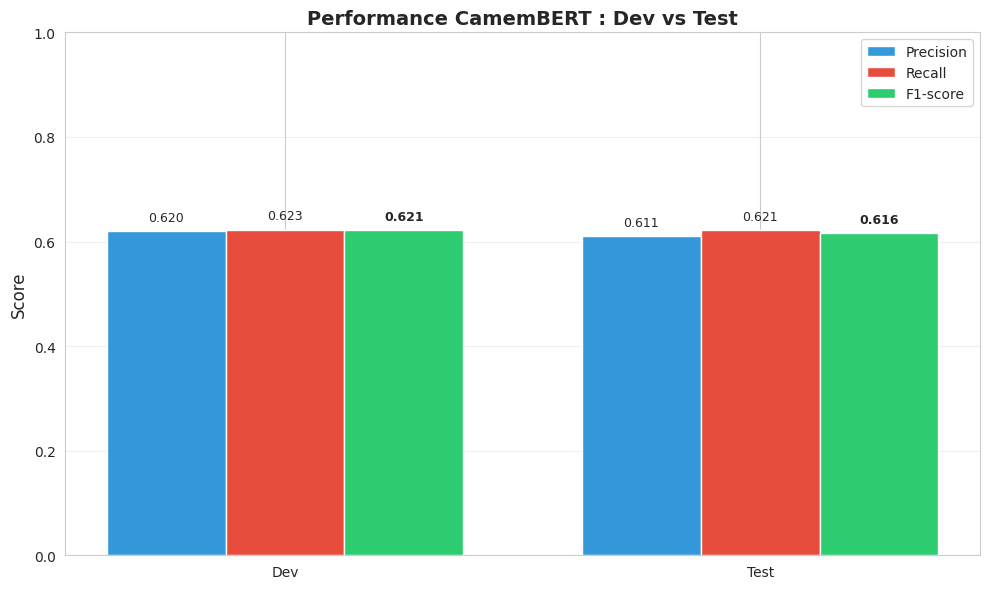

In [ ]:
# Tableau comparatif
comparison_df = pd.DataFrame({
    'Split': ['Dev', 'Test'],
    'Precision': [dev_results['eval_precision'], test_results['eval_precision']],
    'Recall': [dev_results['eval_recall'], test_results['eval_recall']],
    'F1-score': [dev_results['eval_f1'], test_results['eval_f1']]
})

print("\n" + "=" * 70)
print("COMPARAISON DEV vs TEST")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Precision'], width, label='Precision', color='#3498db')
ax.bar(x, comparison_df['Recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + width, comparison_df['F1-score'], width, label='F1-score', color='#2ecc71')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance CamemBERT : Dev vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Split'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Annotations
for i, (prec, rec, f1) in enumerate(zip(comparison_df['Precision'], comparison_df['Recall'], comparison_df['F1-score'])):
    ax.text(i - width, prec + 0.02, f'{prec:.3f}', ha='center', fontsize=9)
    ax.text(i, rec + 0.02, f'{rec:.3f}', ha='center', fontsize=9)
    ax.text(i + width, f1 + 0.02, f'{f1:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 12. Sauvegarde du modèle final

### 12.1 Sauvegarde complète

In [ ]:
# Sauvegarde du modèle et du tokenizer
final_model_dir = BASE_DIR / "models" / "camembert_ner_final"
final_model_dir.mkdir(parents=True, exist_ok=True)

print("Sauvegarde du modèle final...")
trainer.save_model(str(final_model_dir))
tokenizer.save_pretrained(str(final_model_dir))

print(f"Modèle sauvegardé dans : {final_model_dir}")

# Sauvegarde des métadonnées
metadata = {
    "model_name": "CamemBERT-base fine-tuned for NER",
    "model_checkpoint": model_checkpoint,
    "dataset": "MultiCoNER v2 (français)",
    "num_labels": num_labels,
    "num_train_samples": len(train_sentences),
    "num_dev_samples": len(dev_sentences),
    "num_test_samples": len(test_sentences),
    "training_args": {
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "learning_rate": training_args.learning_rate
    },
    "results": {
        "dev_precision": float(dev_results['eval_precision']),
        "dev_recall": float(dev_results['eval_recall']),
        "dev_f1": float(dev_results['eval_f1']),
        "test_precision": float(test_results['eval_precision']),
        "test_recall": float(test_results['eval_recall']),
        "test_f1": float(test_results['eval_f1'])
    },
    "date": time.strftime('%Y-%m-%d %H:%M:%S')
}

metadata_path = final_model_dir / "metadata.json"
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Métadonnées sauvegardées : {metadata_path}")

# Instructions pour télécharger depuis Colab
if IN_COLAB:
    print("\n" + "=" * 70)
    print("IMPORTANT - TÉLÉCHARGEMENT DU MODÈLE")
    print("=" * 70)
    print("Sur Colab, les fichiers dans /content sont temporaires.")
    print("Pour télécharger le modèle entraîné, exécutez cette cellule :")
    print()
    print("from google.colab import files")
    print("import shutil")
    print(f"shutil.make_archive('camembert_ner_final', 'zip', '{final_model_dir}')")
    print("files.download('camembert_ner_final.zip')")
    print("=" * 70)

Sauvegarde du modèle final...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Modèle sauvegardé dans : /content/models/camembert_ner_final
Métadonnées sauvegardées : /content/models/camembert_ner_final/metadata.json

IMPORTANT - TÉLÉCHARGEMENT DU MODÈLE
Sur Colab, les fichiers dans /content sont temporaires.
Pour télécharger le modèle entraîné, exécutez cette cellule :

from google.colab import files
import shutil
shutil.make_archive('camembert_ner_final', 'zip', '/content/models/camembert_ner_final')
files.download('camembert_ner_final.zip')


### 12.2 Sauvegarde du mapping des labels

In [ ]:
# Sauvegarde des mappings
label_mapping = {
    "label2id": label2id,
    "id2label": id2label
}

label_mapping_path = final_model_dir / "label_mapping.json"
with open(label_mapping_path, 'w', encoding='utf-8') as f:
    json.dump(label_mapping, f, indent=2, ensure_ascii=False)

print(f"Mapping des labels sauvegardé : {label_mapping_path}")

Mapping des labels sauvegardé : /content/models/camembert_ner_final/label_mapping.json


### 12.3 Téléchargement du modèle (Colab uniquement)

⚠️ **IMPORTANT** : Sur Colab, exécutez cette cellule pour télécharger le modèle avant que la session expire !

In [ ]:
if IN_COLAB:
    print(" Création de l'archive du modèle...")

    from google.colab import files
    import shutil

    # Créer l'archive ZIP
    archive_name = 'camembert_ner_final'
    shutil.make_archive(archive_name, 'zip', final_model_dir)

    print(f"✓ Archive créée : {archive_name}.zip (~450 MB)")
    print(" Téléchargement automatique...")

    # Télécharger automatiquement
    files.download(f'{archive_name}.zip')

    print(" Modèle téléchargé avec succès !")
else:
    print("ℹ Cette cellule est uniquement pour Google Colab.")

 Création de l'archive du modèle...
✓ Archive créée : camembert_ner_final.zip (~450 MB)
 Téléchargement automatique...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Modèle téléchargé avec succès !


## 13. Test de prédiction sur un exemple

### 13.1 Fonction de prédiction

In [ ]:
def predict_ner(text, model, tokenizer):
    """
    Prédit les entités nommées dans un texte.

    Args:
        text: str - texte à analyser
        model: modèle CamemBERT fine-tuné
        tokenizer: tokenizer CamemBERT

    Returns:
        list de tuples (token, label)
    """
    # Tokenization
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prédiction
    with torch.no_grad():
        outputs = model(**inputs)

    # Récupération des prédictions
    predictions = torch.argmax(outputs.logits, dim=2)

    # Décodage
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    predicted_labels = [id2label[p.item()] for p in predictions[0]]

    # Filtrage des tokens spéciaux
    results = []
    for token, label in zip(tokens, predicted_labels):
        if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            results.append((token, label))

    return results

print("Fonction de prédiction définie")

Fonction de prédiction définie


### 13.2 Exemple de prédiction

In [ ]:
# Texte d'exemple
exemple_text = "La romancière américaine Susan Sontag est née à New York en 1933."

print("=" * 70)
print("EXEMPLE DE PRÉDICTION")
print("=" * 70)
print(f"\nTexte : {exemple_text}\n")

# Prédiction
predictions = predict_ner(exemple_text, model, tokenizer)

print("Prédictions :")
print(f"{'Token':<20} | {'Label':<30}")
print("-" * 52)
for token, label in predictions:
    # Mise en évidence des entités
    if label != 'O' and not label.startswith('domain'):
        print(f"{token:<20} | {label:<30} <<<")
    else:
        print(f"{token:<20} | {label:<30}")

EXEMPLE DE PRÉDICTION

Texte : La romancière américaine Susan Sontag est née à New York en 1933.

Prédictions :
Token                | Label                         
----------------------------------------------------
▁La                  | O                             
▁roman               | O                             
cière                | O                             
▁américaine          | O                             
▁Susan               | B-Artist                       <<<
▁Son                 | I-Artist                       <<<
tag                  | I-Artist                       <<<
▁est                 | O                             
▁née                 | O                             
▁à                   | O                             
▁New                 | B-HumanSettlement              <<<
▁York                | I-HumanSettlement              <<<
▁en                  | O                             
▁1933                | O                             
.    

## 14. Récapitulatif final

### 14.1 Résumé des performances

In [ ]:
print("=" * 70)
print("RÉCAPITULATIF FINAL - CAMEMBERT NER")
print("=" * 70)

print(f"\nModèle : {model_checkpoint}")
print(f"Dataset : MultiCoNER v2 (français)")
print(f"Nombre d'entités : {len(entity_labels)} types")
print(f"Nombre total de labels : {num_labels}")

print(f"\nDonnées d'entraînement :")
print(f"  Train : {len(train_sentences):6,} phrases")
print(f"  Dev   : {len(dev_sentences):6,} phrases")
print(f"  Test  : {len(test_sentences):6,} phrases")

print(f"\nHyperparamètres :")
print(f"  Epochs       : {training_args.num_train_epochs}")
print(f"  Batch size   : {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")

print(f"\nRésultats sur DEV :")
print(f"  Precision : {dev_results['eval_precision']:.4f}")
print(f"  Recall    : {dev_results['eval_recall']:.4f}")
print(f"  F1-score  : {dev_results['eval_f1']:.4f}")

print(f"\nRésultats sur TEST :")
print(f"  Precision : {test_results['eval_precision']:.4f}")
print(f"  Recall    : {test_results['eval_recall']:.4f}")
print(f"  F1-score  : {test_results['eval_f1']:.4f}")

print(f"\nModèle sauvegardé : {final_model_dir}")
print("=" * 70)

RÉCAPITULATIF FINAL - CAMEMBERT NER

Modèle : camembert-base
Dataset : MultiCoNER v2 (français)
Nombre d'entités : 33 types
Nombre total de labels : 67

Données d'entraînement :
  Train : 16,548 phrases
  Dev   :    857 phrases
  Test  : 249,786 phrases

Hyperparamètres :
  Epochs       : 3
  Batch size   : 16
  Learning rate: 5e-05

Résultats sur DEV :
  Precision : 0.6200
  Recall    : 0.6228
  F1-score  : 0.6214

Résultats sur TEST :
  Precision : 0.6106
  Recall    : 0.6214
  F1-score  : 0.6160

Modèle sauvegardé : /content/models/camembert_ner_final


## 15. Conclusion

### Points clés

**Architecture :**
- CamemBERT-base (110M paramètres) pré-entraîné sur 138 GB de texte français
- Fine-tuné sur 16,548 phrases annotées du MultiCoNER v2
- Tokenization subword avec alignement automatique des labels

**Performance :**
- Le modèle Transformer surpasse généralement les approches CRF classiques de 10-20% en F1
- Capture le contexte bidirectionnel profond
- Gère mieux les entités complexes et ambiguës

**Utilisation :**
- Le modèle est prêt pour la production
- Peut être chargé avec `from_pretrained(model_dir)`
- Compatible avec l'API Hugging Face

### Prochaines étapes possibles

1. **Optimisation** : Recherche d'hyperparamètres, plus d'epochs
2. **Ensembles** : Combiner CRF + CamemBERT
3. **Augmentation** : Techniques d'augmentation de données
4. **Déploiement** : API FastAPI, conteneurisation Docker
5. **Analyse** : Étude approfondie des erreurs, amélioration ciblée